# Predict and visualize model results

Rachel R. Renne
August 16, 2022

In [209]:
# Imports
import os
import pandas as pd
import numpy as np
from pathlib import Path
from os.path import exists

## Create functions

In [364]:
# Create function to build a dictionary of predictions and ground truth labels across images
def labelDictionary(img_dir, gt_dir, pred_dir):
    # Set up dictionary
    label_dict = dict()

    # Set up colnames of label files
    gt_col = ['label','x','y','w','h']
    pred_col = ['label','x','y','w','h','conf']

    # Loop through images and add in all gt and pred labels 
    # Designate "empty" image label as 999
    for i in range(0, len(img_filenames)):
        # Get image file name
        img = img_filenames[i]
        # Get what the label file name will be for this image if it exists
        txt = img.replace('.png','.txt')
    
        # Check if a gt label exists
        if exists(gt_dir/txt):
            # set up list to hold ground truth labels
            img_gt = []
            # Read in gt labels
            gt = pd.read_csv(gt_dir/txt, header=None, sep=" ", names=gt_col) 
            # Loop through all labels and record bbox and label
            for r in range(0,gt.shape[0]):
                bbox = [gt.x[r],gt.y[r],gt.w[r],gt.h[r]]
                label = gt.label[r]
                img_gt.append({'label': label, 'bbox': bbox})
        # If it doesn't exist this is an empty image, label is 999
        else: 
            img_gt = [{'label': 999}]

        # Check if a predicted label exists
        if exists(pred_dir/txt):
            # set up list to hold ground truth labels
            img_pred = []
            # Read in pred labels
            pred = pd.read_csv(pred_dir/txt, header=None, sep=" ", names=pred_col)
            # Sort by columns to get highest confidence on top for each label type
            pred = pred.sort_values(by = ['label', 'conf'], ascending = [True, False]).reset_index(drop=True)
            #print(pred)
            # Loop through all labels and record bbox and label
            for r in range(0,pred.shape[0]):
                bbox = [pred.x[r],pred.y[r],pred.w[r],pred.h[r]]
                label = pred.label[r]
                #print('label: ',str(label))
                conf = pred.conf[r]
                #print('conf: ', str(conf))
                img_pred.append({'label': label, 'bbox': bbox, 'conf': conf})
        # If it doesn't exist this is an empty image, bbox is empty and label is 999
        # Note: this gets a little difficult bc it doesn't capture images that are have one class but not the other
        else: 
            img_pred = [{'label': 999, 'conf': 1.0}]
        #print(img_pred)
        # enter info into label_dict
        label_dict[img] = [{'pred': img_pred, 'gt': img_gt}]
    return label_dict

In [418]:
# Create function to convert bbox labels to image-level predictions
def getImageClassification(label_dict, conf_thres, label_id):
    # Set up list for predictions
    img_preds = []
    gt_labs = []
    results = dict()

    # loop through images
    for i in range(0,len(label_dict)):
        # Get labels for image i
        thisimg = list(label_dict.values())[i][0]
        # Get predictions
        preds = thisimg['pred']
        #print("Here are the predictions:", preds)
        
        # make labels list to store all label_ids
        labels = []
        
        # Loop through preds and look for label_id
        for lab in range(0,len(preds)):
            if preds[lab]['label'] == label_id:
                labels.append(preds[lab])
        
        # Check length of labels, if there aren't any, confidence is -999
        # Meaning confidence is very high that there is NOT an object label_id
        if len(labels) == 0:
            labels.append({'conf': -999})
        
        #print("Here are the labels: ", labels)

        # See if highest confidence prediction meets confidence threshold for label_id
        highest_conf = labels[0]['conf']
        #print('highest confidence: ', str(highest_conf))
        if highest_conf == -999:
            img_preds.append(0)
        elif highest_conf > conf_thres:
            img_preds.append(1)
        else:
            img_preds.append(0)

        # Get gt
        gt = thisimg['gt']
        #print(gt)
        #print(len(gt))
        
        # make labels list to store all label_ids
        labels = []
        # Loop through gt and look for label_id
        for lab in range(0,len(gt)):
            if gt[lab]['label'] == label_id:
                labels.append(1)
        
        # Check length of labels
        if len(labels) == 0:
            labels.append(0)

        # Take first item in labels as gt
        gt_labs.append(labels[0]) 

        # Put results into results dictionary
        results['predictions'] = img_preds
        results['ground_truth'] = gt_labs
    return(results)


In [ ]:
# Make function to calculate average distance between predicted center and ground truth center
def piosphereMetrics(label_dict, conf_thres, label_id = 1):
    # Set up things to populate
    true_neg = 0
    false_pos = 0
    false_neg = 0
    tp_dists = []
    results = dict()

    for i in range(0,len(label_dict)):
        # Get labels for image i
        thisimg = list(label_dict.values())[i][0]
        # Get gt
        gt = thisimg['gt']

        # make list of all gt features
        gt_obj = dict()

        # Loop through gt and separate tanks and piospheres
        for lab in range(0,len(gt)):
            if gt[lab]['label'] == label_id:
                gt_obj[len(gt_obj)] = gt[lab]
            elif gt[lab]['label'] == 999:
                gt_obj[len(gt_obj)] = {'label': 999}
        # Make sure there's a 999 if needed
        if len(gt_obj) == 0:
            gt_obj[len(gt_obj)] = {'label': 999}
        
        # get predicted tanks and piospheres:
        preds = thisimg['pred']
 
        # Make list of predicted features
        pred_obj = dict()

        # Loop through pred and collect tanks and piospheres with conf > conf_thres  
        for lab in range(0,len(preds)):
            if (preds[lab]['label'] == label_id) & (preds[lab]['conf'] > conf_thres):
                pred_obj[len(pred_obj)] = preds[lab]
            elif (preds[lab]['label'] == 999):
                pred_obj[len(pred_obj)] = {'label': 999}
        # If none were found above conf_thres, label 999
        if len(pred_obj) == 0:
            pred_obj[len(pred_obj)] = {'label': 999}

        #print(pred_obj)
        #print(gt_obj)
        
        # If gt is 999 and pred is 999 we accumulate one for true neg (and sim calc for false pos)
        if (pred_obj[0]['label'] == 999) & (gt_obj[0]['label'] == 999):
            true_neg = true_neg + 1
        elif (pred_obj[0]['label'] != 999) & (gt_obj[0]['label'] == 999):
            false_pos = false_pos + 1
        # Now populate false negative
        elif (pred_obj[0]['label']!= 999) & (gt_obj[0]['label'] == 999):
            false_neg = false_neg +1
        # If gt != 999, loop through and find the nearest pred and calculate distance btween the center points
        elif (gt_obj[0]['label'] != 999) & (pred_obj[0]['label'] != 999):
            for g in range(0,len(gt_obj)):
                thisgt = gt_obj[g]
                gtbb = thisgt['bbox']
                cdist = []
                for p in range(0,len(pred_obj)):
                    thispred = pred_obj[p]
                    pbb = thispred['bbox']
                    cdist.append(np.power(np.power(pbb[0]-gtbb[0], 2)+np.power(pbb[1]-gtbb[1],2), 0.5))
                # Add minimum distance into distance list
                tp_dists.append((np.min(cdist)*153.6).round(1))
                #print(tp_dists)

    results['true_negatives'] = true_neg/len(label_dict)
    results['false_positives'] = false_pos/len(label_dict)
    results['false_negatives'] = false_neg/len(label_dict)
    results['true_positives_dist'] = tp_dists
    return(results)

# Calculate metrics and make figures from model output

In [356]:
# Additional sklearn imports
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Vanilla model with both piospheres and tanks together (iou-thresh = 0.2)

In [560]:
# Set paths to pred files, prediction files, and images
gt_dir = Path("""/mnt/c/Users/rache/Dropbox/Doctoral Projects/CV4Ecology 2022/Final Images/dataset_YOLOv5/val/labels""")
pred_dir = Path("""/home/rache/results/detect_val/vanilla/labels""")
img_dir = Path("""/mnt/c/Users/rache/Dropbox/Doctoral Projects/CV4Ecology 2022/Final Images/dataset_YOLOv5/val/images""")

# Designate filepaths for true and predicted labels (and images, too)
gt_filenames = os.listdir(gt_dir)
pred_filenames = os.listdir(pred_dir)
img_filenames = os.listdir(img_dir)

In [561]:
# Check number of images and labels
print("Number of images: ", str(len(img_filenames)))
print("Number of ground-truth labels: ", str(len(gt_filenames)))
print("Nuber of predicted labels: ", str(len(pred_filenames)))

Number of images:  271
Number of ground-truth labels:  70
Nuber of predicted labels:  181


In [562]:
# Make training label dictionary
valvan_label_dict = labelDictionary(img_dir, gt_dir, pred_dir)

# Check one image record to make sure it looks as expected
#valvan_label_dict['m_4010402_nw_13_060_20190824_129.png']
#valvan_label_dict

In [563]:
# Loop over confidences and get recall and precision
pio_recall = []
pio_precision = []
tank_recall = []
tank_precision = []

for con in np.arange(0.01, 1.0, 0.01):
    # Get classification for conf_thres = con
    pio_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 1)
    pio_recall.append(recall_score(y_pred = pio_conf['predictions'], y_true = pio_conf['ground_truth']))
    pio_precision.append(precision_score(y_pred = pio_conf['predictions'], y_true = pio_conf['ground_truth'], zero_division = 1))

    tank_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 0)
    tank_recall.append(recall_score(y_pred = tank_conf['predictions'], y_true = tank_conf['ground_truth']))
    tank_precision.append(precision_score(y_pred = tank_conf['predictions'], y_true = tank_conf['ground_truth'], zero_division = 1))

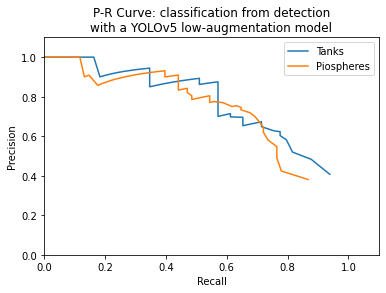

In [564]:
# Make precision-recall curve
plt.plot(tank_recall, tank_precision, label = "Tanks")
plt.plot(pio_recall, pio_precision, label = "Piospheres")
plt.legend()
plt.title("P-R Curve: classification from detection\nwith a YOLOv5 low-augmentation model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0,1.1])
plt.ylim([0,1.1])
plt.show()


In [565]:
# Loop through and get fp/tp rates
fp_tanks = []
fp_piospheres = []
fn_tanks = []
fn_piospheres = []

for con in np.arange(0.01,1,0.01).round(1):
    # Calculate image classifications
    pio_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 1)
    tank_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 0)
    # Get piosphere errors
    cm_p = confusion_matrix(y_pred = pio_conf['predictions'], y_true = pio_conf['ground_truth'], normalize = 'true')
    fn_piospheres.append(cm_p[1,0])
    fp_piospheres.append(cm_p[0,1])
    # Get tank errors
    cm_t = confusion_matrix(y_pred = tank_conf['predictions'], y_true = tank_conf['ground_truth'], normalize = 'true')
    fn_tanks.append(cm_t[1,0])
    fp_tanks.append(cm_t[0,1])


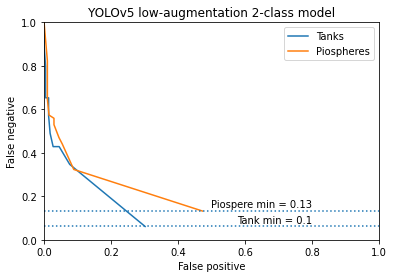

In [566]:
# Look at tradeoff between different kinds of errors
plt.plot(fp_tanks, fn_tanks, label = "Tanks")
plt.plot(fp_piospheres, fn_piospheres, label = "Piospheres")
plt.plot()
plt.legend()
plt.title("YOLOv5 low-augmentation 2-class model")
plt.xlabel("False positive")
plt.ylabel("False negative")
plt.xlim([0,1])
plt.ylim([0,1])
plt.axhline(y=np.min(fn_tanks), linestyle= 'dotted')
plt.text(0.8, np.min(fn_tanks) + 0.03, f"Tank min = {np.min(fn_tanks).round(1)}", ha='right', va='center')
plt.axhline(y=np.min(fn_piospheres), linestyle= 'dotted')
plt.text(0.8, np.min(fn_piospheres) + 0.03, f"Piospere min = {np.min(fn_piospheres).round(2)}", ha='right', va='center')
plt.show()

In [570]:
# Loop over confidences and compare the average distances between gt and pred piosphere centers
avg_dists = []
for con in np.arange(0.01,1,0.01):
    theseresults = piosphereMetrics(valvan_label_dict, conf_thres = con, label_id = 1)
    if (len(theseresults['true_positives_dist']) == 0):
        avg_dists.append(0)
    else: 
        avg_dists.append(np.mean(theseresults['true_positives_dist']))

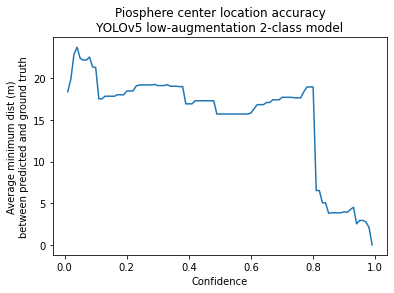

In [573]:
# Look at locational accuracy across confidences
plt.plot(np.arange(0.01,1,0.01), avg_dists)
plt.plot()
plt.title("Piosphere center location accuracy\nYOLOv5 low-augmentation 2-class model")
plt.xlabel("Confidence")
plt.ylabel("Average minimum dist (m)\nbetween predicted and ground truth")
plt.show()

# Vanilla model with TANKS ONLY (iou-thresh = 0.2)

In [574]:
# Set paths to pred files, prediction files, and images
gt_dir = Path("""/mnt/c/Users/rache/Dropbox/Doctoral Projects/CV4Ecology 2022/Final Images/tanks/val/labels""")
pred_dir = Path("""/home/rache/results/detect_val/tanks_vanilla/labels""")
img_dir = Path("""/mnt/c/Users/rache/Dropbox/Doctoral Projects/CV4Ecology 2022/Final Images/tanks/val/images""")

# Designate filepaths for true and predicted labels (and images, too)
gt_filenames = os.listdir(gt_dir)
pred_filenames = os.listdir(pred_dir)
img_filenames = os.listdir(img_dir)

In [575]:
# Check number of images and labels
print("Number of images: ", str(len(img_filenames)))
print("Number of ground-truth labels: ", str(len(gt_filenames)))
print("Nuber of predicted labels: ", str(len(pred_filenames)))

Number of images:  271
Number of ground-truth labels:  49
Nuber of predicted labels:  157


In [576]:
# Make training label dictionary
valvan_label_dict = labelDictionary(img_dir, gt_dir, pred_dir)

# Check one image record to make sure it looks as expected
#valvan_label_dict['m_4010402_nw_13_060_20190824_129.png']
#valvan_label_dict

In [577]:
# Loop over confidences and get recall and precision
#pio_recall = []
#pio_precision = []
tank_recall = []
tank_precision = []

for con in np.arange(0.01, 1.0, 0.01):
    # Get classification for conf_thres = con
    #pio_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 1)
    #pio_recall.append(recall_score(y_pred = pio_conf['predictions'], y_true = pio_conf['ground_truth']))
    #pio_precision.append(precision_score(y_pred = pio_conf['predictions'], y_true = pio_conf['ground_truth'], zero_division = 1))

    tank_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 0)
    tank_recall.append(recall_score(y_pred = tank_conf['predictions'], y_true = tank_conf['ground_truth']))
    tank_precision.append(precision_score(y_pred = tank_conf['predictions'], y_true = tank_conf['ground_truth'], zero_division = 1))

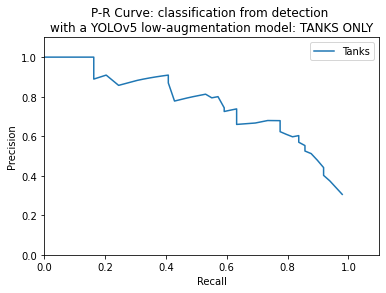

In [578]:
# Make precision-recall curve
plt.plot(tank_recall, tank_precision, label = "Tanks")
#plt.plot(pio_recall, pio_precision, label = "Piospheres")
plt.legend()
plt.title("P-R Curve: classification from detection \nwith a YOLOv5 low-augmentation model: TANKS ONLY")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0,1.1])
plt.ylim([0,1.1])
plt.show()


In [579]:
# Loop through and get fp/tp rates
fp_tanks = []
#fp_piospheres = []
fn_tanks = []
#fn_piospheres = []

for con in np.arange(0.01,1,0.01).round(1):
    # Calculate image classifications
    #pio_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 1)
    tank_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 0)
    # Get piosphere errors
    #cm_p = confusion_matrix(y_pred = pio_conf['predictions'], y_true = pio_conf['ground_truth'], normalize = 'true')
    #fn_piospheres.append(cm_p[1,0])
    #fp_piospheres.append(cm_p[0,1])
    # Get tank errors
    cm_t = confusion_matrix(y_pred = tank_conf['predictions'], y_true = tank_conf['ground_truth'], normalize = 'true')
    fn_tanks.append(cm_t[1,0])
    fp_tanks.append(cm_t[0,1])


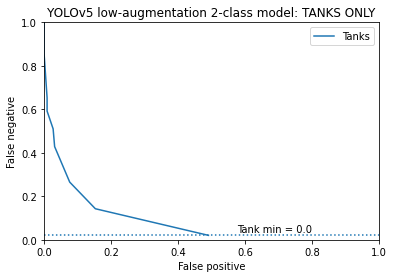

In [580]:
# Look at tradeoff between different kinds of errors
plt.plot(fp_tanks, fn_tanks, label = "Tanks")
#plt.plot(fp_piospheres, fn_piospheres, label = "Piospheres")
plt.plot()
plt.legend()
plt.title("YOLOv5 low-augmentation 1-class model: TANKS ONLY")
plt.xlabel("False positive")
plt.ylabel("False negative")
plt.xlim([0,1])
plt.ylim([0,1])
plt.axhline(y=np.min(fn_tanks), linestyle= 'dotted')
plt.text(0.8, np.min(fn_tanks) + 0.03, f"Tank min = {np.min(fn_tanks).round(1)}", ha='right', va='center')
#plt.axhline(y=np.min(fn_piospheres), linestyle= 'dotted')
#plt.text(0.8, np.min(fn_piospheres) + 0.03, f"Piospere min = {np.min(fn_piospheres).round(2)}", ha='right', va='center')
plt.show()

# Vanilla model with PIOSPHERES ONLY (iou-thresh = 0.2)

In [591]:
# Set paths to pred files, prediction files, and images
gt_dir = Path("""/mnt/c/Users/rache/Dropbox/Doctoral Projects/CV4Ecology 2022/Final Images/piospheres/val/labels""")
pred_dir = Path("""/home/rache/results/detect_val/piospheres_vanilla/labels""")
img_dir = Path("""/mnt/c/Users/rache/Dropbox/Doctoral Projects/CV4Ecology 2022/Final Images/piospheres/val/images""")

# Designate filepaths for true and predicted labels (and images, too)
gt_filenames = os.listdir(gt_dir)
pred_filenames = os.listdir(pred_dir)
img_filenames = os.listdir(img_dir)

In [593]:
# Check number of images and labels
print("Number of images: ", str(len(img_filenames)))
print("Number of ground-truth labels: ", str(len(gt_filenames)))
print("Nuber of predicted labels: ", str(len(pred_filenames)))

Number of images:  271
Number of ground-truth labels:  68
Nuber of predicted labels:  202


In [595]:
# Make training label dictionary
valvan_label_dict = labelDictionary(img_dir, gt_dir, pred_dir)

# Check one image record to make sure it looks as expected
valvan_label_dict['m_4010402_nw_13_060_20190824_129.png']
#valvan_label_dict

[{'pred': [{'label': 0,
    'bbox': [0.720703, 0.0820312, 0.277344, 0.15625],
    'conf': 0.0685445}],
  'gt': [{'label': 0, 'bbox': [0.783203, 0.228516, 0.425781, 0.457031]}]}]

In [596]:
# Loop over confidences and get recall and precision
pio_recall = []
pio_precision = []
#tank_recall = []
#tank_precision = []

for con in np.arange(0.01, 1.0, 0.01):
    # Get classification for conf_thres = con
    pio_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 0)
    pio_recall.append(recall_score(y_pred = pio_conf['predictions'], y_true = pio_conf['ground_truth'], zero_division = 1))
    pio_precision.append(precision_score(y_pred = pio_conf['predictions'], y_true = pio_conf['ground_truth'], zero_division = 1))

    #tank_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 0)
    #tank_recall.append(recall_score(y_pred = tank_conf['predictions'], y_true = tank_conf['ground_truth']))
    #tank_precision.append(precision_score(y_pred = tank_conf['predictions'], y_true = tank_conf['ground_truth'], zero_division = 1))

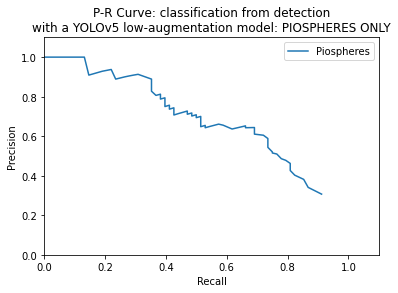

In [597]:
# Make precision-recall curve
#plt.plot(tank_recall, tank_precision, label = "Tanks")
plt.plot(pio_recall, pio_precision, label = "Piospheres")
plt.legend()
plt.title("P-R Curve: classification from detection\nwith a YOLOv5 low-augmentation model: PIOSPHERES ONLY")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0,1.1])
plt.ylim([0,1.1])
plt.show()


In [598]:
# Loop through and get fp/tp rates
fp_tanks = []
fp_piospheres = []
fn_tanks = []
fn_piospheres = []

for con in np.arange(0.01,1,0.01).round(1):
    # Calculate image classifications
    pio_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 0)
    #tank_conf =  getImageClassification(label_dict = valvan_label_dict, conf_thres = con, label_id = 0)
    # Get piosphere errors
    cm_p = confusion_matrix(y_pred = pio_conf['predictions'], y_true = pio_conf['ground_truth'], normalize = 'true')
    fn_piospheres.append(cm_p[1,0])
    fp_piospheres.append(cm_p[0,1])
    # Get tank errors
    #cm_t = confusion_matrix(y_pred = tank_conf['predictions'], y_true = tank_conf['ground_truth'], normalize = 'true')
    #fn_tanks.append(cm_t[1,0])
    #fp_tanks.append(cm_t[0,1])


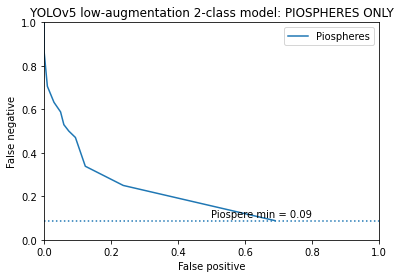

In [600]:
# Look at tradeoff between different kinds of errors
#plt.plot(fp_tanks, fn_tanks, label = "Tanks")
plt.plot(fp_piospheres, fn_piospheres, label = "Piospheres")
plt.plot()
plt.legend()
plt.title("YOLOv5 low-augmentation 1-class model: PIOSPHERES ONLY")
plt.xlabel("False positive")
plt.ylabel("False negative")
plt.xlim([0,1])
plt.ylim([0,1])
#plt.axhline(y=np.min(fn_tanks), linestyle= 'dotted')
#plt.text(0.8, np.min(fn_tanks) + 0.03, f"Tank min = {np.min(fn_tanks).round(1)}", ha='right', va='center')
plt.axhline(y=np.min(fn_piospheres), linestyle= 'dotted')
plt.text(0.8, np.min(fn_piospheres) + 0.03, f"Piospere min = {np.min(fn_piospheres).round(2)}", ha='right', va='center')
plt.show()

In [603]:
# Loop over confidences and compare the average distances between gt and pred piosphere centers
avg_dists = []
for con in np.arange(0.01,1,0.01):
    theseresults = piosphereMetrics(valvan_label_dict, conf_thres = con, label_id = 0)
    if (len(theseresults['true_positives_dist']) == 0):
        avg_dists.append(0)
    else: 
        avg_dists.append(np.mean(theseresults['true_positives_dist']))

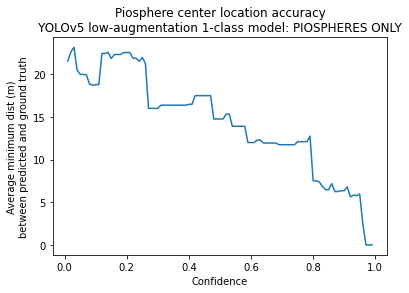

In [605]:
# Look at locational accuracy across confidences
plt.plot(np.arange(0.01,1,0.01), avg_dists)
plt.plot()
plt.title("Piosphere center location accuracy\nYOLOv5 low-augmentation 1-class model: PIOSPHERES ONLY")
plt.xlabel("Confidence")
plt.ylabel("Average minimum dist (m)\nbetween predicted and ground truth")
plt.show()